In [1]:
import pandas as pd
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Collating ATP match level data downloaded from https://github.com/JeffSackmann/tennis_atp.git**

In [2]:
# Loading all downloded CSV files
folder_path='./data'
# Initialize=ing an empty list to hold dataframes
data=[]
files=glob.glob(os.path.join(folder_path,'*.csv'))
# Looping through each file and reading it into a dataframe
for file in files:
    records=pd.read_csv(file)
    records['tourney_date'] = pd.to_datetime(records['tourney_date'],format='%Y%m%d')
    data.append(records)
    print(f"{file}: Records: {records.shape[0]}")
# Concatenating all dataframes into a single dataframe
df=pd.concat(data,ignore_index=True)

./data\atp_matches_2017.csv: Records: 2911
./data\atp_matches_2018.csv: Records: 2897
./data\atp_matches_2019.csv: Records: 2806
./data\atp_matches_2020.csv: Records: 1462
./data\atp_matches_2021.csv: Records: 2733
./data\atp_matches_2022.csv: Records: 2917
./data\atp_matches_2023.csv: Records: 2986
./data\atp_matches_2024.csv: Records: 3076


Step 1: Exploratory Data Analysis

In [3]:
# Converting 'tourney_date' to datetime format and displaying the date range
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
print(f"ATP match stats from: {df['tourney_date'].min().strftime('%Y')} to {df['tourney_date'].max().strftime('%Y')}")
# No of players
print(f"Number of unique players: {df['winner_name'].nunique() + df['loser_name'].nunique()}")

ATP match stats from: 2017 to 2024
Number of unique players: 1688


In [4]:
# Checking for missing values
df.isna().sum()

tourney_id                0
tourney_name              0
surface                  53
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           12777
winner_entry          18500
winner_name               0
winner_hand               0
winner_ht               106
winner_ioc                0
winner_age                3
loser_id                  0
loser_seed            16402
loser_entry           16815
loser_name                0
loser_hand                1
loser_ht                297
loser_ioc                 0
loser_age                 3
score                     0
best_of                   0
round                     0
minutes                1107
w_ace                   735
w_df                    735
w_svpt                  735
w_1stIn                 735
w_1stWon                735
w_2ndWon                735
w_SvGms                 735
w_bpSaved               735
w_bpFaced           

In [5]:
# For seed, imputing with 0 as players can be unseeded
df['winner_seed']=df['winner_seed'].fillna(0)
df['loser_seed']=df['loser_seed'].fillna(0)
# For entry, assigning 'Unseeded'
df['winner_entry']=df['winner_entry'].fillna('Unseeded')
df['loser_entry']=df['loser_entry'].fillna('Unseeded')
# For height, using 188cm as its the global median
df['winner_ht']=df['winner_ht'].fillna(188)
df['loser_ht']=df['loser_ht'].fillna(188)
# For walkovers/Retirements and No stats filling with 0
stat_cols = ['w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms',
             'w_bpSaved','w_bpFaced','l_ace','l_df','l_svpt','l_1stIn','l_1stWon',
             'l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced','minutes']
df[stat_cols] = df[stat_cols].fillna(0)


In [6]:
# For ranking using forward fill method
def fill_player_ranks(df):
    for player_type in ['winner', 'loser']:
        player_id = f"{player_type}_id"
        rank = f"{player_type}_rank"
        df = df.sort_values('tourney_date')
        df[rank] = df.groupby(player_id)[rank].ffill().bfill()
    return df
df = fill_player_ranks(df)
df[['winner_rank', 'loser_rank']] = df[['winner_rank', 'loser_rank']].fillna(1000)

In [7]:
# Filtering data specifically for Australian Open
ao_data = df[
    (df['surface'] == 'Hard') &
    (df['best_of'] == 5) &
    (df['tourney_level'].isin(['G'])) 
].copy().reset_index(drop=True)

In [8]:
print("Hard Court Grand Slam Tournaments:", ao_data['tourney_name'].unique())
# Standardizing tournament name for US Open
ao_data['tourney_name'] = ao_data['tourney_name'].replace('Us Open', 'US Open')
# Validating the unique tournament names 
print("Hard Court Grand Slam Tournaments:", ao_data['tourney_name'].unique())

Hard Court Grand Slam Tournaments: ['Australian Open' 'US Open' 'Us Open']
Hard Court Grand Slam Tournaments: ['Australian Open' 'US Open']


In [9]:
ao_data.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Step 2: Feature Engineering

In [10]:
# Differential Features
ao_data['rank_diff'] = ao_data['winner_rank'] - ao_data['loser_rank']
ao_data['rank_pts_diff'] = ao_data['winner_rank_points'] - ao_data['loser_rank_points']
ao_data['age_diff'] = ao_data['winner_age'] - ao_data['loser_age']
ao_data['height_diff'] = ao_data['winner_ht'] - ao_data['loser_ht']
# Per game statistics
ao_data['w_ace_per_game'] = ao_data['w_ace'] / (ao_data['w_SvGms'] + 1)
ao_data['w_df_per_game'] = ao_data['w_df'] / (ao_data['w_SvGms'] + 1)
ao_data['l_ace_per_game'] = ao_data['l_ace'] / (ao_data['l_SvGms'] + 1)
ao_data['l_df_per_game'] = ao_data['l_df'] / (ao_data['l_SvGms'] + 1)
# Serve statistics
ao_data['w_1st_pct'] = np.clip(ao_data['w_1stIn']/np.maximum(ao_data['w_svpt'],1), 0,1)
ao_data['w_1st_win_pct'] = np.clip(ao_data['w_1stWon']/np.maximum(ao_data['w_1stIn'],1), 0,1)
ao_data['w_bp_save_pct'] = np.clip(ao_data['w_bpSaved']/np.maximum(ao_data['w_bpFaced'],1), 0,1)

ao_data['l_1st_pct'] = np.clip(ao_data['l_1stIn']/np.maximum(ao_data['l_svpt'],1), 0,1)
ao_data['l_1st_win_pct'] = np.clip(ao_data['l_1stWon']/np.maximum(ao_data['l_1stIn'],1), 0,1)
ao_data['l_bp_save_pct'] = np.clip(ao_data['l_bpSaved']/np.maximum(ao_data['l_bpFaced'],1), 0,1)
# Match intensity 
ao_data['match_length'] = ao_data['minutes'] / 60  # in hours

Step 3: Visualisations

In [11]:
feature_set = ['rank_diff','rank_pts_diff','age_diff','height_diff',
               'w_ace_per_game','w_df_per_game','l_ace_per_game','l_df_per_game',
               'w_1st_pct','w_1st_win_pct','l_1st_pct','l_1st_win_pct',
               'w_bp_save_pct','l_bp_save_pct','match_length']

**Does higher 1st serve win % = match victory?**

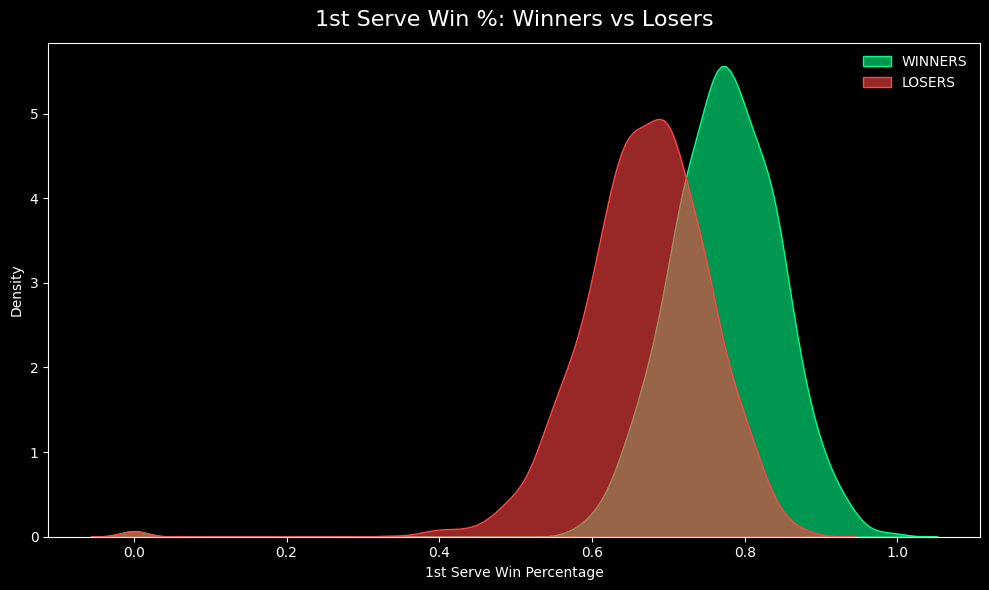

In [12]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.kdeplot(
    ao_data['w_1st_win_pct'],
    fill=True,
    alpha=0.6,
    label='WINNERS',color='#00FF88'
)
sns.kdeplot(
    ao_data['l_1st_win_pct'],
    fill=True,
    alpha=0.6,
    label='LOSERS',color='#FF4444'
)
plt.title('1st Serve Win %: Winners vs Losers', fontsize=16, pad=12)
plt.xlabel('1st Serve Win Percentage')
plt.ylabel('Density')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


- Winners peak upto 70-80% while losers stay at 60-70% of 1st serve win %
- There is a gap of +12%, suggesting that players who dominate the 1st serve end up winning the match.

**How dominant is rank difference?**

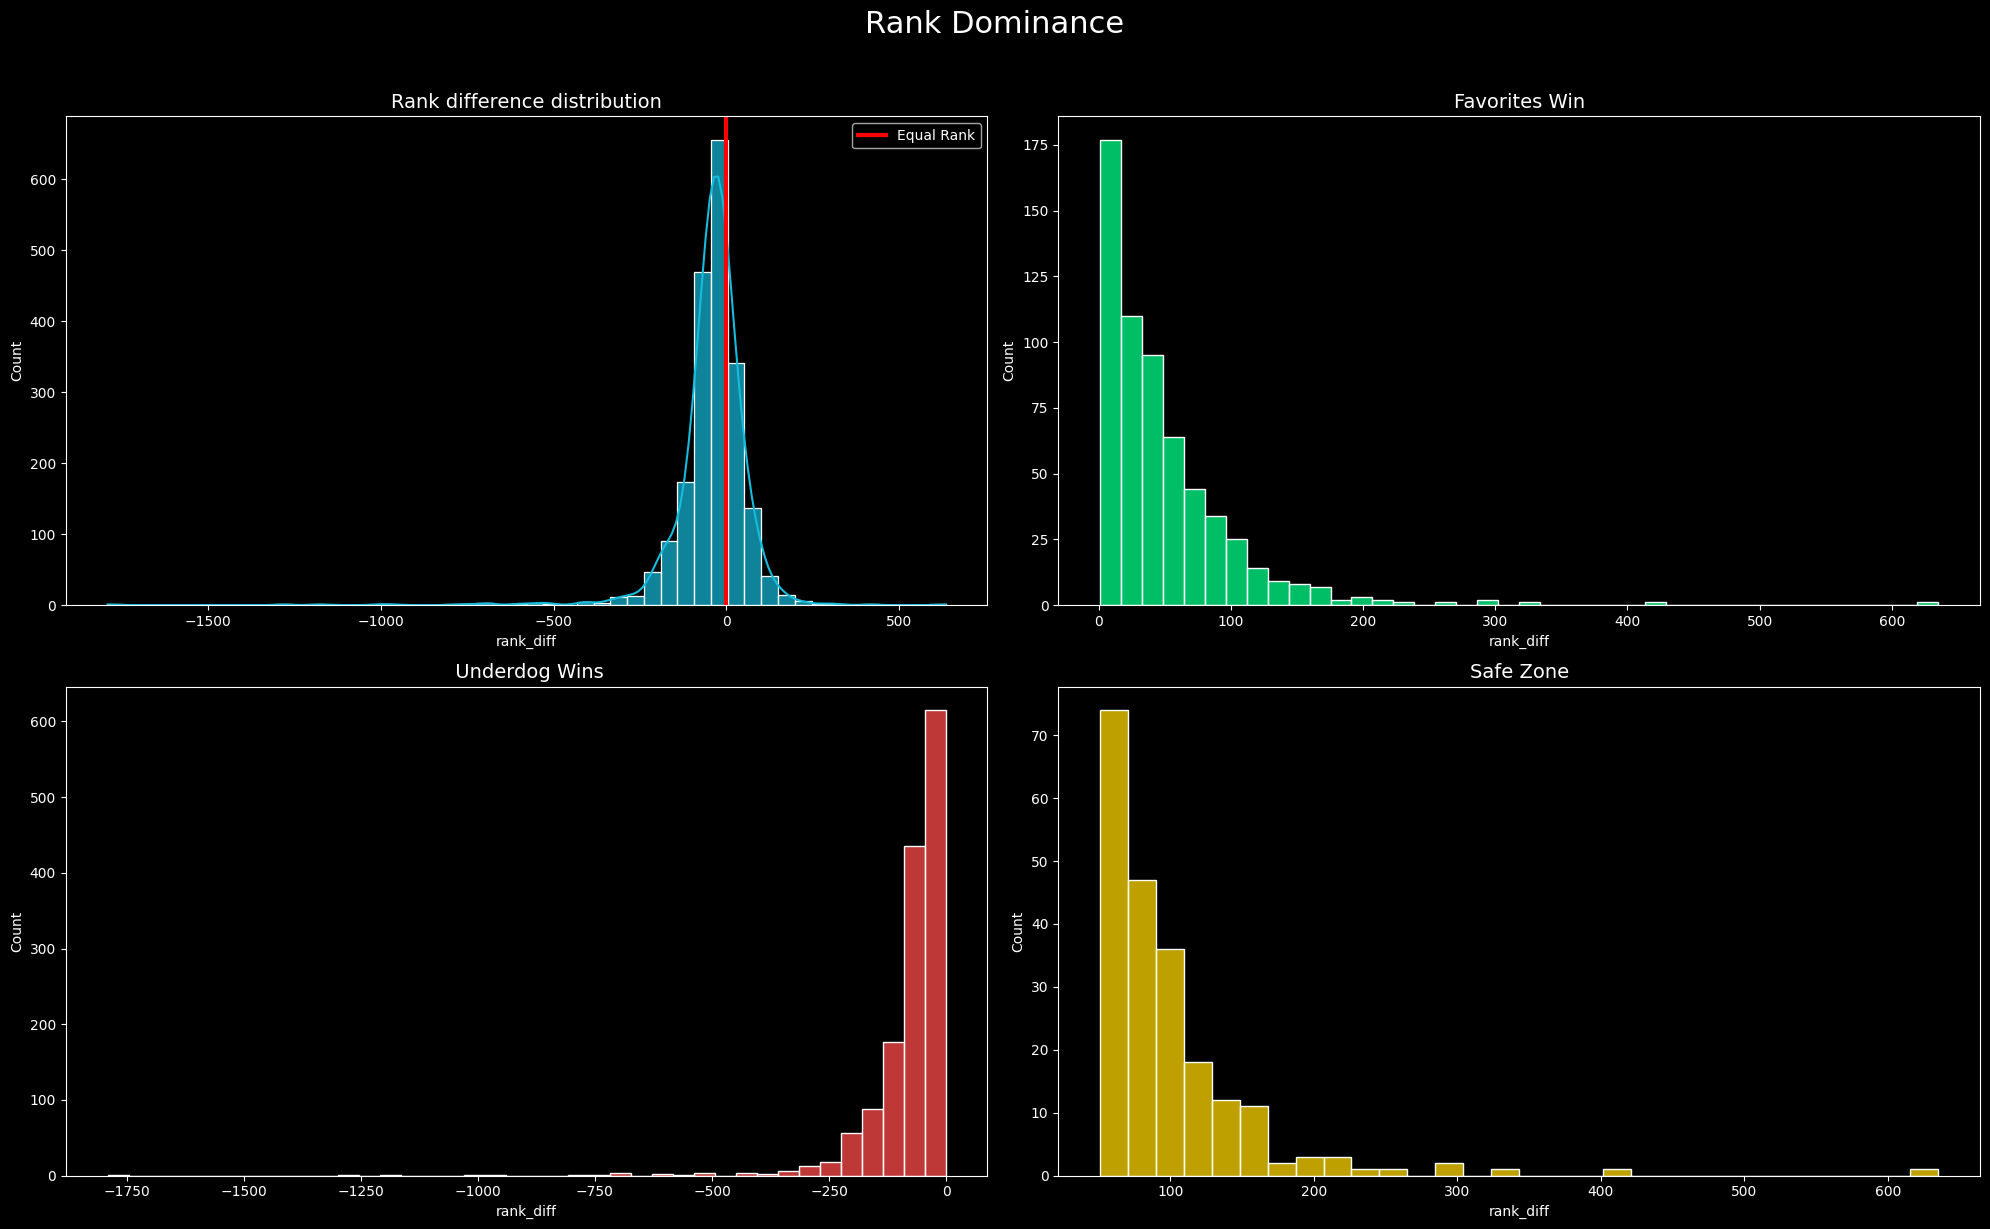

In [13]:
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Rank Dominance',
    fontsize=22, color='white', y=1.02
)
sns.histplot(
    ao_data['rank_diff'],
    bins=50,
    color="#15BCDD",
    kde=True,
    alpha=0.7,
    ax=axes[0, 0]
)
axes[0, 0].axvline(0, color='red', lw=3, label='Equal Rank')
axes[0, 0].set_title(
    'Rank difference distribution',
    fontsize=14, color='white'
)
axes[0, 0].legend()
# players with positive rank difference (ie: higher rank wins)
favorites = ao_data[ao_data['rank_diff'] > 0]
sns.histplot(
    favorites['rank_diff'],
    bins=40,
    color="#00FF88",
    ax=axes[0, 1]
)
axes[0, 1].set_title(
    'Favorites Win',
    fontsize=14, color='white'
)
# players with +50 rank difference (ie: near-certain wins)
safe = ao_data[ao_data['rank_diff'] > 50]
sns.histplot(
    safe['rank_diff'],
    bins=30,
    color="#FFD700",
    ax=axes[1, 1]
)
axes[1, 1].set_title(
    'Safe Zone',
    fontsize=14, color='white'
)
# players with negative rank difference (ie: low rank wins)
underdogs = ao_data[ao_data['rank_diff'] < 0]
sns.histplot(
    underdogs['rank_diff'],
    bins=40,
    color="#FF4C4C",
    ax=axes[1, 0]
)
axes[1, 0].set_title(
    ' Underdog Wins',
    fontsize=14, color='white'
)
plt.tight_layout()
plt.show()


- Ranking alone is a weak when the gap is small
- Upsets (lower rank player winning) are hard to determine as they cluster near 0.
- As the rank gap increases, higher ranked players usually win more consistently.
- When the difference exceed +50, match outcomes become highly predictable.

**Does the rank difference affect how long a match lasts?**

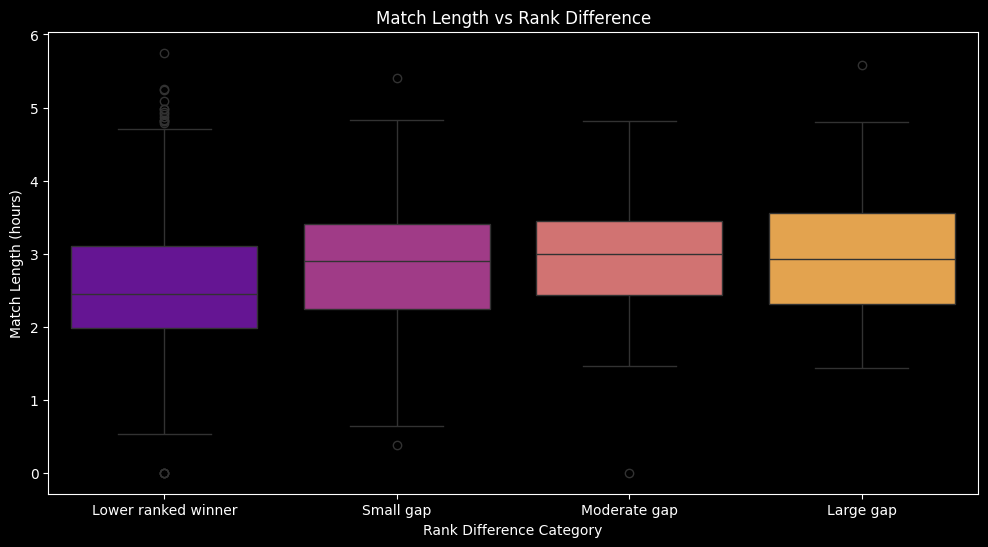

In [14]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
rank_groups = pd.cut(
    ao_data['rank_diff'],
    bins=[-200, 0, 50, 100, 500],
    labels=['Lower ranked winner', 'Small gap', 'Moderate gap', 'Large gap']
)
sns.boxplot(
    x=rank_groups,
    y=ao_data['minutes'] / 60,
    palette='plasma'
)
plt.xlabel('Rank Difference Category')
plt.ylabel('Match Length (hours)')
plt.title('Match Length vs Rank Difference')
plt.show()

- When players are ranked similarly, matches are longer and less predictable.
- Whereas when one player is ranked higher, matches become predictable and shorter.
- Larger rank difference does not always mean short matches.

**Is height advantage real?**

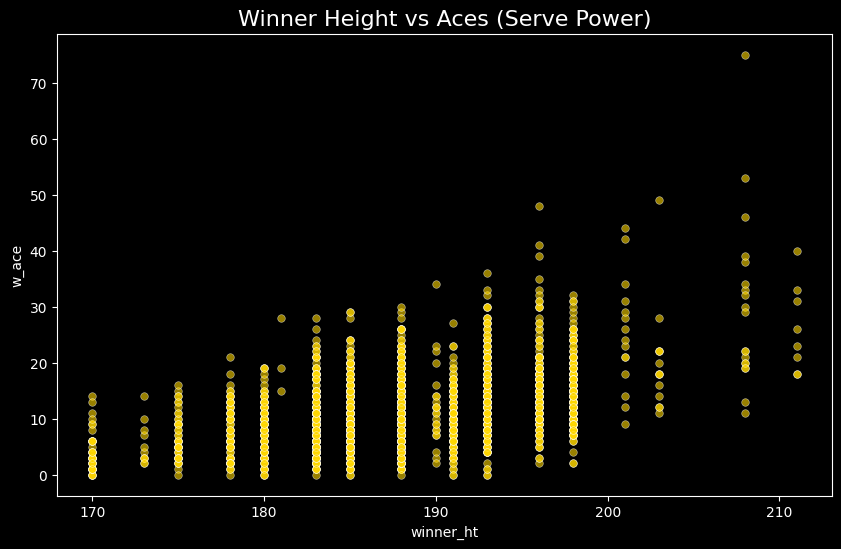

In [15]:
plt.figure(figsize=(10,6))
plt.style.use('dark_background')
sns.scatterplot(x=ao_data['winner_ht'], y=ao_data['w_ace'], alpha=0.6, color='#FFD700', s=30)
plt.title('Winner Height vs Aces (Serve Power)', fontsize=16, color='white')
plt.show()


- Height does give a clear serve advantage but it does not guarentee winning.

**Do Winners Save More Break Points Under Pressure?**

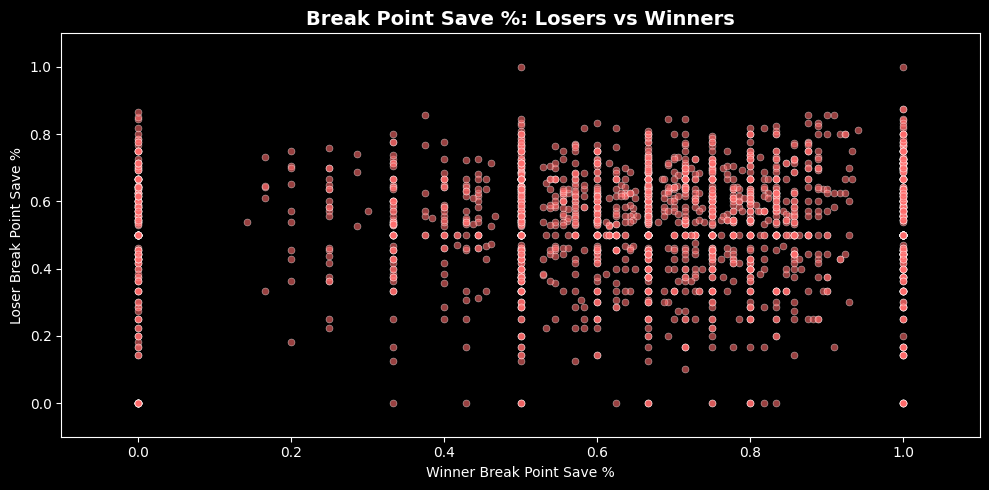

In [16]:
plt.style.use('dark_background')
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=ao_data['w_bp_save_pct'],
    y=ao_data['l_bp_save_pct'],
    color='#FF6B6B',
    alpha=0.6,
    s=25
)
plt.title(
    'Break Point Save %: Losers vs Winners',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Winner Break Point Save %')
plt.ylabel('Loser Break Point Save %')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()


- Winners have higher break-point save percentages.
- Higher breakpoint save percentage impoves the chance of winning bu it is not deterministic.

**Does Age influence match outcomes?**

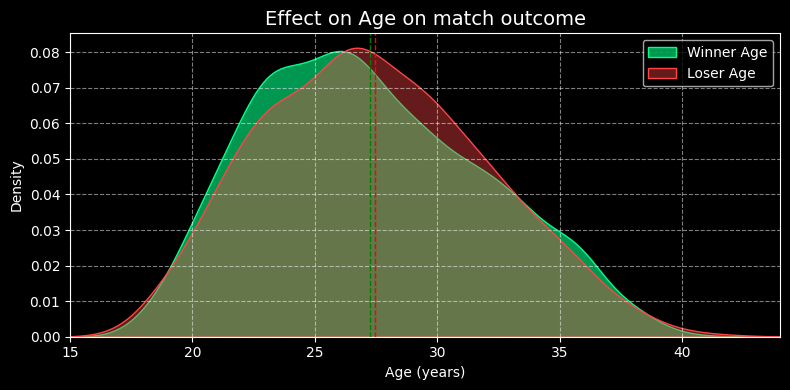

In [17]:
plt.style.use('dark_background')
plt.figure(figsize=(8, 4))
sns.kdeplot(ao_data['winner_age'], label='Winner Age', fill=True, alpha=0.6, color='#00FF88')
sns.kdeplot(ao_data['loser_age'],  label='Loser Age',  fill=True, alpha=0.4, color='#FF4444')
w_mean = ao_data['winner_age'].mean()
l_mean = ao_data['loser_age'].mean()
plt.axvline(w_mean, color='green', linestyle='--', linewidth=1)
plt.axvline(l_mean, color='red', linestyle='--', linewidth=1)
plt.title("Effect on Age on match outcome", fontsize=14)
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(max(15, np.floor(min(ao_data['winner_age'].min(), ao_data['loser_age'].min()) - 1)),
         min(50, np.ceil(max(ao_data['winner_age'].max(), ao_data['loser_age'].max()) + 1)))
plt.tight_layout()
plt.show()


- Age has little to no direct impact on match outcomes.

**Which features actually matter when predicting who wins?**

In [18]:
feature_name_map = {
    'rank_diff': 'Rank Difference',
    'rank_pts_diff': 'Ranking Points Difference',
    'age_diff': 'Age Difference',
    'winner_ht': 'Winner Height (cm)',
    'height_diff': 'Height Difference (cm)',
    'w_1st_win_pct': 'Winner 1st Serve Win %',
    'l_1st_win_pct': 'Loser 1st Serve Win %',
    'w_1st_pct': 'Winner 1st Serve In %',
    'l_1st_pct': 'Loser 1st Serve In %',
    'w_bp_save_pct': 'Winner Break Point Save %',
    'l_bp_save_pct': 'Loser Break Point Save %',
    'w_ace_per_game': 'Winner Aces per Game',
    'l_ace_per_game': 'Loser Aces per Game',
    'w_df_per_game': 'Winner Double Faults per Game',
    'l_df_per_game': 'Loser Double Faults per Game',
    'match_length': 'Match Length (minutes)'
}


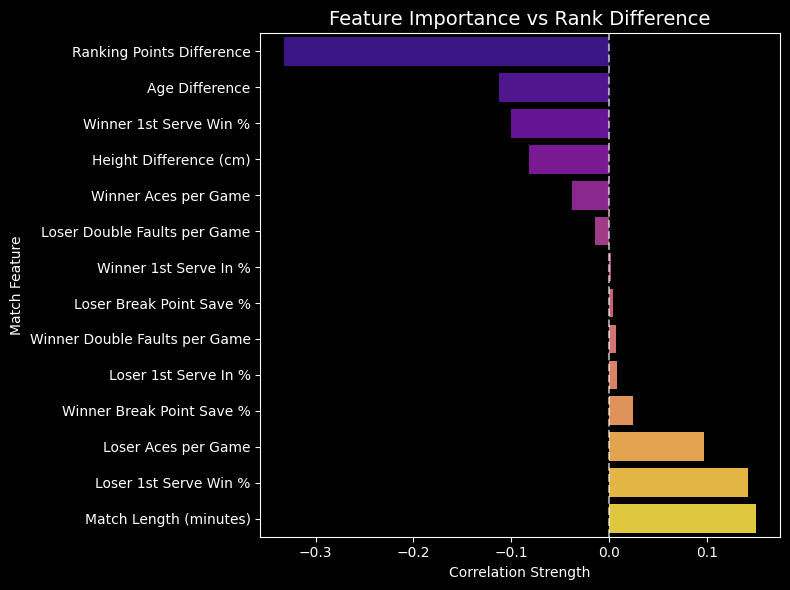

In [19]:
plt.style.use('dark_background')
feature_corr = (
    ao_data[feature_set]
    .corr()['rank_diff']
    .drop('rank_diff')
    .sort_values()
)
feature_corr.index = feature_corr.index.map(
    lambda x: feature_name_map.get(x, x)
)
plt.figure(figsize=(8,6))
sns.barplot(
    x=feature_corr.values,
    y=feature_corr.index,
    palette='plasma'
)
plt.axvline(0, color='white', linestyle='--', alpha=0.6)
plt.title(
    'Feature Importance vs Rank Difference',
    fontsize=14)
plt.xlabel('Correlation Strength')
plt.ylabel('Match Feature')
plt.tight_layout()
plt.show()


In [20]:
# Exporting combined and cleaned data to a CSV file
ao_data.to_csv('./ao_match_data_cleaned.csv', index=False)
df.to_csv('./atp_match_data_cleaned.csv', index=False)